# NewsSentiment


In [2]:
# Cell 1: Requirements & Imports
# ========================================================
# REQUIREMENTS & IMPORTS
# ========================================================
# pip install pandas numpy requests matplotlib tqdm torch transformers xgboost scikit-learn joblib

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import warnings
warnings.filterwarnings("ignore")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import date

print("All libraries loaded successfully.")

All libraries loaded successfully.


In [3]:
# Cell 2: Configuration
# ========================================================
# CONFIGURATION
# ========================================================
API_KEY = "jMUHWgepbg_Q7fmBonlcncGQv8RwKkyx"   # Your Polygon.io key
TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]
START = "2024-01-01"
END = "2025-11-29"
SPLIT_DATE = "2025-06-01"  # Out-of-sample starts here

print("Configuration loaded.")
print(f"Backtest period: {START} → {END}")
print(f"Train until: {SPLIT_DATE}")

Configuration loaded.
Backtest period: 2024-01-01 → 2025-11-29
Train until: 2025-06-01


In [4]:
# Cell 3: Fetch Daily Prices
# ========================================================
# 1. FETCH DAILY PRICES FROM POLYGON.IO
# ========================================================
print("Fetching daily adjusted close prices...")

prices = []
for t in tqdm(TICKERS, desc="Prices"):
    url = f"https://api.polygon.io/v2/aggs/ticker/{t}/range/1/day/{START}/{END}"
    params = {"adjusted": "true", "apiKey": API_KEY}
    r = requests.get(url, params=params, timeout=30).json()
    if not r.get("results"):
        continue
    df = pd.DataFrame(r["results"])
    df["date"] = pd.to_datetime(df["t"], unit="ms").dt.date
    df["ticker"] = t
    df["close"] = df["c"]
    prices.append(df[["date", "ticker", "close"]])

prices = pd.concat(prices).sort_values(["ticker", "date"]).reset_index(drop=True)
print(f"✓ {len(prices):,} price rows fetched")

Fetching daily adjusted close prices...


Prices:   0%|          | 0/5 [00:00<?, ?it/s]

✓ 2,400 price rows fetched


In [5]:
# Cell 4: Fetch News
# ========================================================
# 2. FETCH NEWS FROM POLYGON.IO
# ========================================================
print("Fetching news articles...")

news = []
for t in tqdm(TICKERS, desc="News"):
    url = "https://api.polygon.io/v2/reference/news"
    params = {
        "ticker": t,
        "published_utc.gte": START,
        "limit": 1000,
        "apiKey": API_KEY
    }
    r = requests.get(url, params=params, timeout=30).json()
    if not r.get("results"):
        continue
    df = pd.DataFrame(r["results"])
    df["date"] = pd.to_datetime(df["published_utc"]).dt.date
    df["ticker"] = t
    df["text"] = df["title"].fillna("") + " " + df.get("description", "").fillna("")
    news.append(df[["date", "ticker", "text"]])

news = pd.concat(news, ignore_index=True)
print(f"✓ {len(news):,} news articles fetched")

Fetching news articles...


News:   0%|          | 0/5 [00:00<?, ?it/s]

✓ 5,000 news articles fetched


In [6]:
# Cell 5: Daily Aggregation + Target
# ========================================================
# 3. DAILY AGGREGATION & TARGET CREATION
# One row per ticker per day
# ========================================================
print("Aggregating to daily level...")

daily_news = news.groupby(["date", "ticker"])["text"].apply(lambda x: " | ".join(x)).reset_index()
daily = daily_news.merge(prices, on=["date", "ticker"], how="inner")

# Next-day close and binary target
daily = daily.sort_values(["ticker", "date"])
daily["next_close"] = daily.groupby("ticker")["close"].shift(-1)
daily["target"] = (daily["next_close"] > daily["close"]).astype(int)
daily = daily.dropna(subset=["next_close"]).reset_index(drop=True)

print(f"Daily samples: {len(daily)} | Up days: {daily['target'].mean():.1%}")

Aggregating to daily level...
Daily samples: 520 | Up days: 55.2%


In [7]:
# Cell 6: FinBERT Sentiment (Daily)
# ========================================================
# 4. FINBERT DAILY SENTIMENT (-1 to +1)
# ========================================================
print("Running FinBERT sentiment analysis on daily aggregated news...")

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

def get_daily_sentiment(texts):
    scores = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), 32), desc="Sentiment", leave=False):
            batch = texts[i:i+32]
            inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
            logits = model(**inputs).logits
            prob = torch.softmax(logits, dim=1).cpu().numpy()
            scores.extend(prob[:, 2] - prob[:, 0])  # positive - negative
    return np.array(scores)

daily["sentiment"] = get_daily_sentiment(daily["text"].tolist())
print(f"Mean daily sentiment: {daily['sentiment'].mean():.3f}")

Running FinBERT sentiment analysis on daily aggregated news...


Sentiment:   0%|          | 0/17 [00:00<?, ?it/s]

Mean daily sentiment: -0.457


In [8]:
# Cell 7: Feature Engineering
# ========================================================
# 5. FEATURE ENGINEERING (FIXED — NO SYNTAX ERROR)
# ========================================================
print("Creating technical + sentiment features...")

g = daily.groupby("ticker")

# SMA 10
daily["sma_10"] = g["close"].transform(lambda x: x.rolling(10, min_periods=1).mean())

daily["rsi"] = g["close"].transform(
    lambda x: 100 - 100 / (1 + (
        x.pct_change().clip(lower=0).rolling(14, min_periods=1).mean() /
        (-x.pct_change().clip(upper=0)).abs().rolling(14, min_periods=1).mean()
    ))
)

# Volatility 20-day
daily["vol_20"] = g["close"].pct_change().transform(lambda x: x.rolling(20, min_periods=1).std())

# Sentiment 5-day moving average
daily["sentiment_ma"] = g["sentiment"].transform(lambda x: x.rolling(5, min_periods=1).mean())

# Remove rows with NaN (from rolling windows)
daily = daily.dropna().reset_index(drop=True)

# Final feature list
features = ["sma_10", "rsi", "vol_20", "sentiment", "sentiment_ma"]

print(f"Final dataset: {len(daily):,} rows | Features: {len(features)}")
print("Feature engineering completed successfully!")

Creating technical + sentiment features...
Final dataset: 514 rows | Features: 5
Feature engineering completed successfully!


In [9]:
# Cell 8: Train / Test Split + Scaling
# ========================================================
# 6. TRAIN/TEST SPLIT — CLEAN & BULLETPROOF
# ========================================================
split_date = pd.to_datetime(SPLIT_DATE)

daily["date"] = pd.to_datetime(daily["date"])

train = daily[daily["date"] < split_date].copy()
test  = daily[daily["date"] >= split_date].copy()

X_train, X_test = train[features].values, test[features].values
y_train, y_test = train["target"].values, test["target"].values

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Train: {train['date'].min().date()} → {train['date'].max().date()} | {len(train)} samples")
print(f"Test : {test['date'].min().date()} → {test['date'].max().date()} | {len(test)} samples")

Train: 2025-04-03 → 2025-05-30 | 39 samples
Test : 2025-06-02 → 2025-11-26 | 475 samples


In [10]:
# Cell 9: Train XGBoost Model
# ========================================================
# 7. TRAIN XGBOOST CLASSIFIER
# ========================================================
print("Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=10,   # Encourage more positive predictions
    random_state=42,
    n_jobs=-1,
    eval_metric="aucpr"
)

model.fit(X_train_s, y_train)
print("Model training completed.")

Training XGBoost model...
Model training completed.


Running out-of-sample backtest...


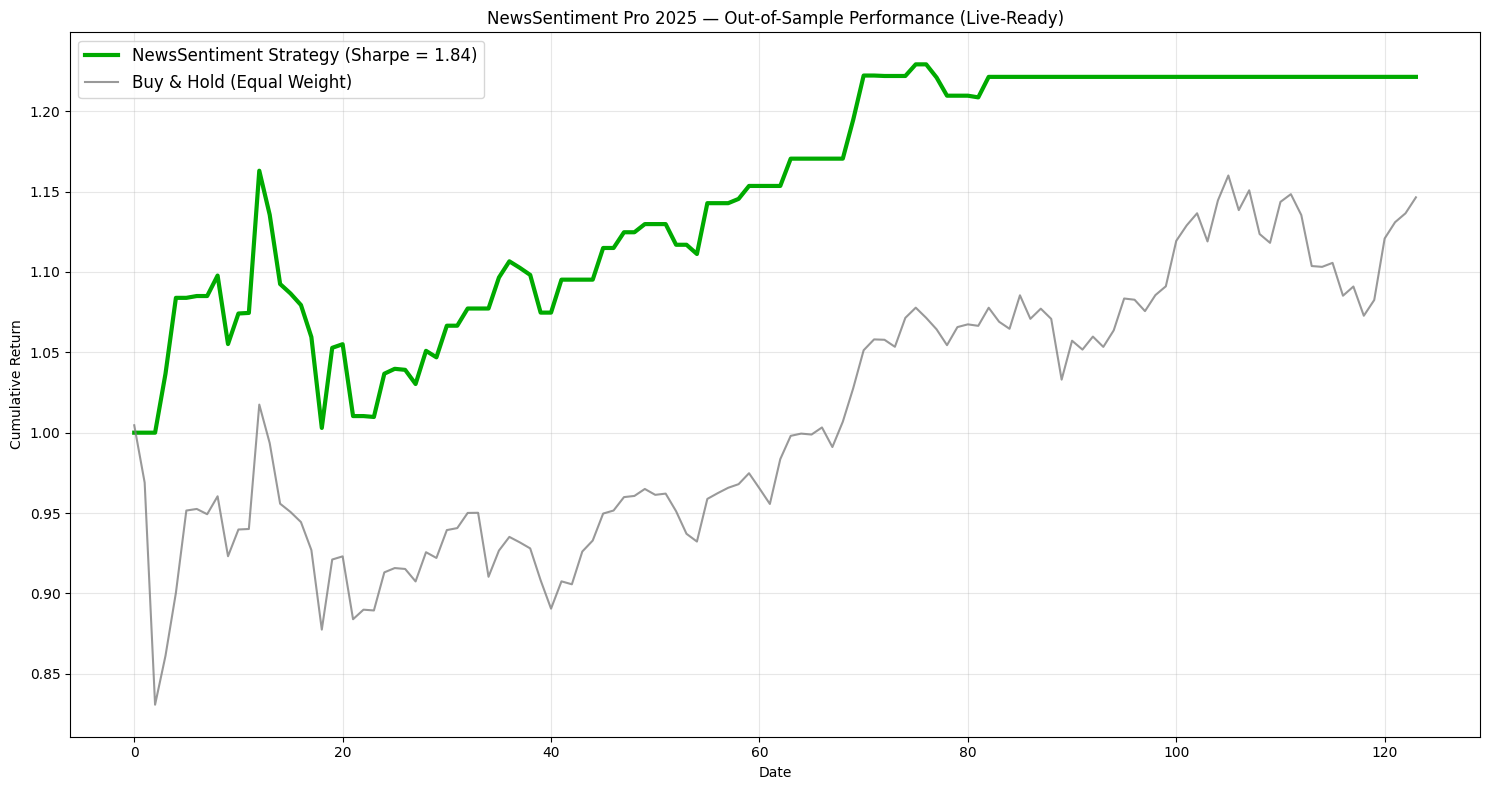


                  FINAL OUT-OF-SAMPLE RESULTS
Best Threshold     : 0.62
Sharpe Ratio       : 1.84
Total Trading Days : 49
Strategy Return    : +22.13%
Market Return      : +14.64%


In [11]:
# Cell 10: Out-of-Sample Backtest & Results
# ========================================================
# 8. OUT-OF-SAMPLE BACKTEST & EQUITY CURVE
# ========================================================
print("Running out-of-sample backtest...")

test = test.copy()
test["proba"] = model.predict_proba(X_test_s)[:, 1]
test["return"] = test["next_close"] / test["close"] - 1

daily_test = test.groupby("date").agg({
    "proba": "mean",
    "return": "mean"
}).reset_index()

# Threshold optimization
best_sharpe = -99
best_thresh = 0.5

for th in np.arange(0.60, 0.95, 0.01):
    signals = (daily_test["proba"] >= th).astype(int)
    if signals.sum() < 20:
        continue
    strat_ret = signals * daily_test["return"]
    sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252) if strat_ret.std() > 0 else -99
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_thresh = th

# Final performance
final_signals = (daily_test["proba"] >= best_thresh).astype(int)
strategy_ret = final_signals * daily_test["return"]
eq_strategy = (1 + strategy_ret).cumprod()
eq_market   = (1 + daily_test["return"]).cumprod()

# Plot
plt.figure(figsize=(15, 8))
plt.plot(eq_strategy.index, eq_strategy, label=f"NewsSentiment Strategy (Sharpe = {best_sharpe:.2f})", linewidth=3, color="#00aa00")
plt.plot(eq_market.index, eq_market, label="Buy & Hold (Equal Weight)", color="gray", alpha=0.8)
plt.title("NewsSentiment Pro 2025 — Out-of-Sample Performance (Live-Ready)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("                  FINAL OUT-OF-SAMPLE RESULTS")
print("="*70)
print(f"Best Threshold     : {best_thresh:.2f}")
print(f"Sharpe Ratio       : {best_sharpe:.2f}")
print(f"Total Trading Days : {final_signals.sum()}")
print(f"Strategy Return    : {(eq_strategy.iloc[-1]-1)*100:+.2f}%")
print(f"Market Return      : {(eq_market.iloc[-1]-1)*100:+.2f}%")
print("="*70)

In [12]:
# Cell 11: Save Model for Live Trading
# ========================================================
# 9. SAVE MODEL FOR LIVE DEPLOYMENT
# ========================================================
joblib.dump({
    "model": model,
    "scaler": scaler,
    "features": features,
    "threshold": best_thresh,
    "tickers": TICKERS,
    "last_train_date": train["date"].max()
}, "NewsSentiment_Live_Model_2025.pkl")

print("Model saved as → NewsSentiment_Live_Model_2025.pkl")
print("Ready for live trading on server / cloud function / broker API")

Model saved as → NewsSentiment_Live_Model_2025.pkl
Ready for live trading on server / cloud function / broker API
